<a href="https://colab.research.google.com/github/NidaNabi/Time_series_of_network_dataset/blob/main/Time_series_of_network_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#installing libraries for visualization

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import manifold
from sklearn.cluster import AgglomerativeClustering as ac
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:

!pip install opentsne

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.2 MB/s eta 0:00:00


In [ ]:
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization

# Importing the data and exploring

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/My Drive/Colab Notebooks/networkdata.parquet"
df=pd.read_parquet(path)
df.head()

,ts,DEST_NE_NAME,Procedure Count,TCP Syn Count,HTTP 1xx Count,HTTP 2xx Count,HTTP 3xx Count,HTTP 4xx Count,HTTP 5xx Count,Total Video Count,...,UL Data Volume (MB),Total Data Volume (MB),Total Video GB,DL Throughput (kbps),UL Throughput (kbps),Average Video DL Throughput (kbps),Average Effective DL Throughput (kbps),Average Effective UL Throughput (kbps),Average Peak DL Throughput (kbps),Average Peak UL Throughput (kbps)
0,2022-10-04,ABN_193735_VC,313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.93,13.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-10-04,ABN_193741_VC,361.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.88,8.90,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-10-04,ABN_193749_VC,468.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.81,13.93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-10-04,ABN_193778_VC,331.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.83,10.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-10-04,ABN_195709_VC,147.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.90,6.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#exploring data
df=df.sample(200000)
df.shape

(200000, 63)

In [ ]:
#create a column "min" specifying which rows/data points arriving that minute
df['min'] = df['ts'].dt.minute

In [ ]:
#extracting important features from teh dataframe
df=df[['DNS Failure Latency (msec)',
       'DNS Success Latency (msec)', 'Internet Latency (msec)',
       'Round Trip Time (msec)', 'HTTP Latency (msec)',
       'DL Data Volume (MB)', 'UL Data Volume (MB)',
       'DL Throughput (kbps)',
       'UL Throughput (kbps)','ts','DEST_NE_NAME','min']]

In [ ]:
df0=df[['DNS Failure Latency (msec)',
       'DNS Success Latency (msec)', 'Internet Latency (msec)',
       'Round Trip Time (msec)', 'HTTP Latency (msec)',
       'DL Data Volume (MB)', 'UL Data Volume (MB)',
       'DL Throughput (kbps)',
       'UL Throughput (kbps)','ts','DEST_NE_NAME','min']]


# Preprocessing the data

In [ ]:

scaler = StandardScaler()
r = df[['ts','DEST_NE_NAME','min']]
s = scaler.fit_transform(df.drop(['ts','DEST_NE_NAME','min'],axis=1))
t = pd.DataFrame(s,columns=['DNS Failure Latency (msec)',
       'DNS Success Latency (msec)', 'Internet Latency (msec)',
       'Round Trip Time (msec)', 'HTTP Latency (msec)',
       'DL Data Volume (MB)', 'UL Data Volume (MB)',
       'DL Throughput (kbps)',
       'UL Throughput (kbps)'])
df = pd.concat([t.reset_index(drop=True),r.reset_index(drop=True)],axis=1)
df.shape

(200000, 12)

# Making a reference embedding and adding new data to it.
Here we make a reference data at "min"=0 and then embed data at "min"=5,"min"=10,"min"=15...upto "min"=55 to reference.

In [ ]:
#here x is reference dataset
x = df[df["min"]==0]
dff=df0[df0['min']==0]
z = dff

x =x.to_numpy()
x.shape

(16768, 9)

In [ ]:
affinities_train = affinity.PerplexityBasedNN(
    x,
    perplexity=40,
    metric="euclidean",
    n_jobs=8,
    random_state=0,
    verbose=True,
)

===> Finding 120 nearest neighbors using Annoy approximate search using euclidean distance...
   --> Time elapsed: 9.29 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 1.03 seconds


In [ ]:
init_train = initialization.pca(x, random_state=0)

In [ ]:
embedding_train = TSNEEmbedding(
    init_train,
    affinities_train,
  #  learning_rate=1000,
    negative_gradient_method="fft",
  #  n_jobs=8,
    verbose=True,
)

In [ ]:
embedding_train_1 = embedding_train.optimize(n_iter=250, exaggeration=12, momentum=0.5)

===> Running optimization with exaggeration=12.00, lr=1397.33 for 250 iterations...
Iteration   50, KL divergence 4.9641, 50 iterations in 1.8238 sec
Iteration  100, KL divergence 3.7850, 50 iterations in 2.0989 sec
Iteration  150, KL divergence 3.4096, 50 iterations in 1.7341 sec
Iteration  200, KL divergence 3.2141, 50 iterations in 1.7157 sec
Iteration  250, KL divergence 3.0915, 50 iterations in 1.6901 sec
   --> Time elapsed: 9.07 seconds


In [ ]:
embedding_train_2 = embedding_train_1.optimize(n_iter=500, momentum=0.8)

===> Running optimization with exaggeration=1.00, lr=1397.33 for 500 iterations...
Iteration   50, KL divergence 2.1874, 50 iterations in 1.7010 sec
Iteration  100, KL divergence 1.6302, 50 iterations in 1.7424 sec
Iteration  150, KL divergence 1.3347, 50 iterations in 2.5661 sec
Iteration  200, KL divergence 1.1589, 50 iterations in 2.8486 sec
Iteration  250, KL divergence 1.0453, 50 iterations in 3.5623 sec
Iteration  300, KL divergence 0.9714, 50 iterations in 4.4592 sec
Iteration  350, KL divergence 0.9226, 50 iterations in 5.5962 sec
Iteration  400, KL divergence 0.8902, 50 iterations in 5.9236 sec
Iteration  450, KL divergence 0.8672, 50 iterations in 8.3623 sec
Iteration  500, KL divergence 0.8485, 50 iterations in 10.2311 sec
   --> Time elapsed: 47.00 seconds


In [ ]:
embedding_train_2

TSNEEmbedding([[-36.80868709, -28.82417439],
               [ 27.072481  , -40.2615283 ],
               [  7.00630084,  49.87850146],
               ...,
               [-47.28210804,  14.53896357],
               [ -7.19307372, -24.2771679 ],
               [-10.03392412, -66.32244466]])

In [ ]:
df3 = pd.DataFrame(embedding_train_2, columns = ['comp_1','comp_2'])
df4 = pd.concat([df3.reset_index(drop=True),z.reset_index(drop=True)],axis=1)
df4.sample(5)

,comp_1,comp_2,DNS Failure Latency (msec),DNS Success Latency (msec),Internet Latency (msec),Round Trip Time (msec),HTTP Latency (msec),DL Data Volume (MB),UL Data Volume (MB),DL Throughput (kbps),UL Throughput (kbps),ts,DEST_NE_NAME,min
12542,-56.018230,7.085392,0.0,0.0,0.0,0.0,0.0,3.01,4.02,0.0,0.0,2022-10-04,SPB_eNB781378,0
1497,8.340263,76.836455,0.0,0.0,0.0,0.0,0.0,11.70,12.19,0.0,0.0,2022-10-04,GRZ_eNB203461,0
11441,-13.301622,-66.273025,0.0,0.0,0.0,0.0,0.0,0.96,2.03,0.0,0.0,2022-10-04,KRN_eNB455210,0
6475,28.760689,23.455364,0.0,0.0,0.0,0.0,0.0,8.85,7.47,0.0,0.0,2022-10-04,SRT_eNB642680,0
13825,-64.276062,27.127429,0.0,0.0,0.0,0.0,0.0,3.88,4.22,0.0,0.0,2022-10-04,KZN_eNB164367,0


In [ ]:
#embedding
x_test = df[df["min"]==5]
dff=df0[df0['min']==5]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_1 = embedding_test.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df5 = pd.DataFrame(embedding_test_1, columns = ['comp_1','comp_2'])
df6 = pd.concat([df5.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)


===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.55 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.17 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 251059.7100, 50 iterations in 0.3785 sec
Iteration  100, KL divergence 247578.6097, 50 iterations in 0.4040 sec
Iteration  150, KL divergence 243587.3854, 50 iterations in 0.3918 sec
Iteration  200, KL divergence 238310.7699, 50 iterations in 0.3851 sec
Iteration  250, KL divergence 230394.8184, 50 iterations in 0.4045 sec
   --> Time elapsed: 1.96 seconds


In [ ]:
x_test = df[df["min"]==10]
dff=df0[df0['min']==10]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test= x_test.to_numpy()

embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df7 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df8 = pd.concat([df7.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.93 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 199074.5981, 50 iterations in 0.4037 sec
Iteration  100, KL divergence 198948.1402, 50 iterations in 0.4056 sec
Iteration  150, KL divergence 198892.2340, 50 iterations in 0.4214 sec
Iteration  200, KL divergence 198853.6586, 50 iterations in 0.4304 sec
Iteration  250, KL divergence 198825.5341, 50 iterations in 0.4130 sec
   --> Time elapsed: 2.07 seconds


In [ ]:
x_test = df[df["min"]==15]
dff=df0[df0['min']==15]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df9 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df10 = pd.concat([df9.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.54 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 201647.0313, 50 iterations in 0.4119 sec
Iteration  100, KL divergence 201532.2087, 50 iterations in 0.4166 sec
Iteration  150, KL divergence 201481.4889, 50 iterations in 0.4084 sec
Iteration  200, KL divergence 201448.9439, 50 iterations in 0.4258 sec
Iteration  250, KL divergence 201424.2174, 50 iterations in 0.4256 sec
   --> Time elapsed: 2.09 seconds


In [ ]:
x_test = df[df["min"]==20]
dff=df0[df0['min']==20]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test= x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df11 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df12 = pd.concat([df11.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.52 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 199107.9239, 50 iterations in 0.3987 sec
Iteration  100, KL divergence 198988.6599, 50 iterations in 0.4187 sec
Iteration  150, KL divergence 198936.4874, 50 iterations in 0.4368 sec
Iteration  200, KL divergence 198899.6876, 50 iterations in 0.4127 sec
Iteration  250, KL divergence 198874.3950, 50 iterations in 0.4103 sec
   --> Time elapsed: 2.08 seconds


In [ ]:
x_test = df[df["min"]==25]
dff=df0[df0['min']==25]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df13 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df14 = pd.concat([df13.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.57 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 202368.0910, 50 iterations in 0.4156 sec
Iteration  100, KL divergence 202242.6784, 50 iterations in 0.4529 sec
Iteration  150, KL divergence 202195.8983, 50 iterations in 0.4142 sec
Iteration  200, KL divergence 202167.2921, 50 iterations in 0.4219 sec
Iteration  250, KL divergence 202147.2663, 50 iterations in 0.4122 sec
   --> Time elapsed: 2.12 seconds


In [ ]:
x_test = df[df["min"]==30]
dff=df0[df0['min']==30]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df15 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df16 = pd.concat([df15.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.45 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 198548.7878, 50 iterations in 0.6060 sec
Iteration  100, KL divergence 198440.8890, 50 iterations in 0.5528 sec
Iteration  150, KL divergence 198393.2034, 50 iterations in 0.4148 sec
Iteration  200, KL divergence 198364.0752, 50 iterations in 0.4043 sec
Iteration  250, KL divergence 198337.4528, 50 iterations in 0.4253 sec
   --> Time elapsed: 2.40 seconds


In [ ]:
x_test = df[df["min"]==35]
dff=df0[df0['min']==35]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df17 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df18 = pd.concat([df17.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.58 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 199444.0009, 50 iterations in 0.4126 sec
Iteration  100, KL divergence 199322.4937, 50 iterations in 0.4201 sec
Iteration  150, KL divergence 199273.1859, 50 iterations in 0.4188 sec
Iteration  200, KL divergence 199244.5531, 50 iterations in 0.4041 sec
Iteration  250, KL divergence 199226.0619, 50 iterations in 0.4096 sec
   --> Time elapsed: 2.07 seconds


In [ ]:
x_test = df[df["min"]==40]
dff=df0[df0['min']==40]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df19 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df20 = pd.concat([df19.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.56 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 199725.7979, 50 iterations in 0.4055 sec
Iteration  100, KL divergence 199602.1973, 50 iterations in 0.4190 sec
Iteration  150, KL divergence 199548.1261, 50 iterations in 0.4038 sec
Iteration  200, KL divergence 199518.9281, 50 iterations in 0.4232 sec
Iteration  250, KL divergence 199500.6395, 50 iterations in 0.6922 sec
   --> Time elapsed: 2.35 seconds


In [ ]:

x_test = df[df["min"]==45]
dff=df0[df0['min']==45]
z_test =dff
x_test= x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df21 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df22 = pd.concat([df21.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.53 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.15 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 198626.9986, 50 iterations in 0.3937 sec
Iteration  100, KL divergence 198513.7496, 50 iterations in 0.4078 sec
Iteration  150, KL divergence 198467.1197, 50 iterations in 0.4082 sec
Iteration  200, KL divergence 198442.9373, 50 iterations in 0.4169 sec
Iteration  250, KL divergence 198424.6420, 50 iterations in 0.4014 sec
   --> Time elapsed: 2.03 seconds


In [ ]:
x_test = df[df["min"]==50]
dff=df0[df0['min']==50]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df23 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df24 = pd.concat([df23.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.46 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.14 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 196469.8927, 50 iterations in 0.4056 sec
Iteration  100, KL divergence 196368.3695, 50 iterations in 0.4068 sec
Iteration  150, KL divergence 196325.5866, 50 iterations in 0.4069 sec
Iteration  200, KL divergence 196299.9314, 50 iterations in 0.4055 sec
Iteration  250, KL divergence 196279.4289, 50 iterations in 0.4269 sec
   --> Time elapsed: 2.05 seconds


In [ ]:
x_test = df[df["min"]==55]
dff=df0[df0['min']==55]
z_test =dff
x_test = x_test.drop(['ts','DEST_NE_NAME','min'],axis=1)
x_test=x_test.to_numpy()
embedding_test_2 = embedding_train_2.prepare_partial(
    x_test,
    initialization="median",
    k=25,
    perplexity=5,
)
embedding_test_3 = embedding_test_2.optimize(n_iter=250,learning_rate=0.1, momentum=0.8)
df25 = pd.DataFrame(embedding_test_3, columns = ['comp_1','comp_2'])
df26 = pd.concat([df25.reset_index(drop=True),z_test.reset_index(drop=True)],axis=1)

===> Finding 15 nearest neighbors in existing embedding using Annoy approximate search...
   --> Time elapsed: 2.99 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.16 seconds
===> Running optimization with exaggeration=1.00, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 199536.4104, 50 iterations in 0.4076 sec
Iteration  100, KL divergence 199404.2519, 50 iterations in 0.4292 sec
Iteration  150, KL divergence 199347.0192, 50 iterations in 0.4145 sec
Iteration  200, KL divergence 199315.7159, 50 iterations in 0.4185 sec
Iteration  250, KL divergence 199295.3053, 50 iterations in 0.4398 sec
   --> Time elapsed: 2.11 seconds


In [ ]:
df9 = pd.concat([df4,df6,df8,df10,df12,df14,df16,df18,df20,df22,df24,df26],axis=0)
df9['dummy_column_for_size'] = 1.


In [ ]:
df9.sort_values(by="min",ascending=True,inplace=True)
#now,we have a df9 dataframe which has original columns plus the 2D coordinates of tsne embedding ponits

# Visualising data
Here,we visualize our time-series data at different minutes (controlled by a time slider).There is a dropdown where we can select a particular feature of data and visualize it using gradient overlay. Also,cluster centers are marked using k means.

In [ ]:
#installing libraries for intaractive tools
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

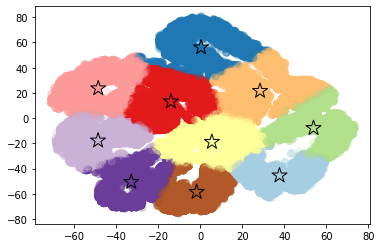

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
km = KMeans(
        n_clusters=10, init='random',
        n_init=10, max_iter=10000,
        tol=1e-04, random_state=0
    )
y_km = km.fit_predict(df9[['comp_1','comp_2']])
plt.scatter(df9['comp_1'], df9['comp_2'], c=y_km, s=50, cmap=plt.cm.Paired, alpha=0.2)
plt.scatter(km.cluster_centers_[:, 0],km.cluster_centers_[:, 1],
        s=250, marker='*', label='centroids',
        edgecolor='black',
       c=np.arange(0,10),cmap=plt.cm.Paired,)

In [ ]:
properties=['none','DNS Failure Latency (msec)','DNS Success Latency (msec)', 'Internet Latency (msec)','Round Trip Time (msec)', 'HTTP Latency (msec)','DL Data Volume (MB)', 'UL Data Volume (MB)']

In [ ]:

def f(min,prop):
    dff = df9[df9["min"]==min]
    y_km = km.fit_predict(dff[['comp_1','comp_2']])
    if prop=='none':

        fig, ax = plt.subplots(figsize=(20, 16))
        plt.scatter(dff['comp_1'], dff['comp_2'], c=y_km ,s=50, cmap=plt.cm.Paired, alpha=0.7)
        plt.scatter(km.cluster_centers_[:, 0],km.cluster_centers_[:, 1],s=250, marker='*', label='centroids',edgecolor='black',c=np.arange(0,10),cmap=plt.cm.Paired,)
        fig.show()
    else:
        fig, ax = plt.subplots(figsize=(20, 16))
        #plt.scatter(dff['comp_1'], dff['comp_2'], c=y_km ,s=150, cmap=plt.cm.Paired, alpha=0.1)
        sc=plt.scatter(dff['comp_1'], dff['comp_2'], c=dff[prop] ,s=50, cmap='Wistia', alpha=1)#'Blues'
        ax.legend(*sc.legend_elements(), title='clusters')
        plt.scatter(km.cluster_centers_[:, 0],km.cluster_centers_[:, 1],s=250, marker='*', label='centroids',edgecolor='black',c=np.arange(0,10),cmap=plt.cm.Paired,)
        fig.show()

interact(f, min=(0, 55,5),prop=properties)

interactive(children=(IntSlider(value=25, description='min', max=55, step=5), Dropdown(description='prop', opt…

<function __main__.f(min, prop)>

In [ ]:
#for howering datapoints this plot can be used
import plotly.express as px
def f2(x2):
           cluster= px.scatter(df9, x="comp_1", y="comp_2", animation_frame="min",
           size='dummy_column_for_size',size_max=5, color=df9[x2],

           hover_data={x2:True,'comp_1': False,
                             'comp_2':  False,
                             'dummy_column_for_size':False,
                       'min':False
                        },
           #range_x=[-200,200], range_y=[-200,200])
           )
           cluster.show()



In [ ]:
#interact(f2, x2=['DL Throughput (kbps)','DNS Failure Latency (msec)','DNS Success Latency (msec)', 'Internet Latency (msec)','Round Trip Time (msec)',
     #         'HTTP Latency (msec)','DL Data Volume (MB)', 'UL Data Volume (MB)','DL Throughput (kbps)',
         #      'UL Throughput (kbps)'])